In [1]:
import re
import ast
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download(['stopwords','wordnet'])

import spacy
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import tqdm
import pyLDAvis
import pyLDAvis.gensim
from pprint import pprint

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/fivecentsly/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/fivecentsly/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
df = pd.read_csv('recipe_clean.csv')
df.head(1)

,link,title,ratings,num_reviews,ingredients,servings,cook_time,calorie,fat_g,carb_g,protein_g,cholesterol_mg,sodium_mg
0,https://www.allrecipes.com/recipe/100164/chip-...,Chip Truck Fries,4.44,44,"['6 baking potatoes, cut into 1/4 inch slices'...",4.0,60,369.0,14.0,56.3,6.5,0.0,478.0


In [3]:
df.shape

(4776, 13)

# Preprocess

In [4]:
# keep title and ingredients for text cleaning
df = df[['title', 'ingredients']]
df.ingredients[0]

"['6 baking potatoes, cut into 1/4 inch slices', '1/4 cup vegetable oil', '2 teaspoons seasoned salt']"

In [5]:
# define a function to convert list to str
def list_to_str(x):
    """
    Convert list to str
    """
    # extract list from str
    x = ast.literal_eval(x)
    
    # convert list to str
    x = ','.join(x)

    return x

In [6]:
# apply function to df
df.ingredients = df.ingredients.apply(list_to_str)
df.ingredients[0]

'6 baking potatoes, cut into 1/4 inch slices,1/4 cup vegetable oil,2 teaspoons seasoned salt'

### Remove number and punctuation

In [7]:
# create a list for text data
data = df.ingredients.values.tolist()

# remove number and punctuation
data = [re.sub(r'[^a-zA-Z]', ' ', sent.lower()) for sent in data] 
data[0]

'  baking potatoes  cut into     inch slices     cup vegetable oil   teaspoons seasoned salt'

In [8]:
# remove units
units = ['spoon','pound','cup','quart','ounce','pint','degree','dash','pinch','pack','halve','bunch','inch']
for unit in units:
    expre = re.compile('\w*' + unit + '\w*')
    data = [re.sub(expre, '', sent).strip() for sent in data]

data[0]

<>:4: DeprecationWarning: invalid escape sequence \w
<>:4: DeprecationWarning: invalid escape sequence \w
<>:4: DeprecationWarning: invalid escape sequence \w
<>:4: DeprecationWarning: invalid escape sequence \w
<>:4: DeprecationWarning: invalid escape sequence \w
<>:4: DeprecationWarning: invalid escape sequence \w
<ipython-input-8-33fd2784d652>:4: DeprecationWarning: invalid escape sequence \w
  expre = re.compile('\w*' + unit + '\w*')
<ipython-input-8-33fd2784d652>:4: DeprecationWarning: invalid escape sequence \w
  expre = re.compile('\w*' + unit + '\w*')


'baking potatoes  cut into      slices      vegetable oil    seasoned salt'

In [9]:
# remove duplicated whitespace
data = [' '.join(sent.split()) for sent in data]

data[0]

'baking potatoes cut into slices vegetable oil seasoned salt'

### Tokenize words

In [10]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(sentence))

data_words = list(sent_to_words(data))
data_words[0]

['baking',
 'potatoes',
 'cut',
 'into',
 'slices',
 'vegetable',
 'oil',
 'seasoned',
 'salt']

### Make bigram

In [11]:
# build a bigram model
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) 

# faster way to get a sentence clubbed as a bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)

In [12]:
data_bigram = [bigram_mod[doc] for doc in data_words]
data_bigram[0]

['baking',
 'potatoes',
 'cut',
 'into',
 'slices',
 'vegetable',
 'oil',
 'seasoned',
 'salt']

### Remove stopwords and lemmatize

In [13]:
stop_words = stopwords.words('english')

# remove stopwords
data_nonstop = [[word for word in doc if word not in stop_words] for doc in data_bigram]
data_nonstop[0]

['baking', 'potatoes', 'cut', 'slices', 'vegetable', 'oil', 'seasoned', 'salt']

In [14]:
# keep only noun and adj
def lemmatization(texts, allowed_postags=['NOUN','ADJ']): 
    texts_out = []
    for sent in texts:
        doc = nlp(' '.join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

# initialize spacy 'en' model, keeping only tagger component
nlp = spacy.load('en', disable=['parser', 'ner'])

# lemmatize
data_lemmatized = lemmatization(data_nonstop, allowed_postags=['NOUN','ADJ'])
data_lemmatized[0]

['potato', 'slice', 'vegetable', 'oil', 'salt']

In [15]:
# check word frequencies
vocab = dict()
for doc in data_lemmatized:
    for word in doc:
        if word not in vocab.keys():
            vocab[word] = 1
        else:
            vocab[word] += 1

In [16]:
vocab

{'potato': 556,
 'slice': 537,
 'vegetable': 629,
 'oil': 2173,
 'salt': 2875,
 'irish': 3,
 'large': 862,
 'diced': 122,
 'tomato': 916,
 'juice': 374,
 'stock': 111,
 'black': 2126,
 'pepper': 3651,
 'taste': 2514,
 'dark': 26,
 'green': 866,
 'savoy': 2,
 'cabbage': 102,
 'leave': 193,
 'salmon': 206,
 'onion': 2731,
 'celery': 409,
 'lemon': 440,
 'dill': 99,
 'hot': 280,
 'sauce': 1213,
 'cayenne': 243,
 'granule': 3,
 'powder': 468,
 'sliced': 100,
 'sweet': 222,
 'cherry': 69,
 'pea': 114,
 'fresh': 2108,
 'parsley': 398,
 'pecan': 44,
 'mayonnaise': 183,
 'plain': 28,
 'low': 34,
 'fat': 51,
 'yogurt': 14,
 'mustard': 258,
 'olive': 1501,
 'bean': 543,
 'whole': 324,
 'kernel': 119,
 'corn': 293,
 'brown': 288,
 'sugar': 728,
 'butter': 1105,
 'flour': 738,
 'tortilla': 101,
 'cheese': 1277,
 'purpose': 603,
 'baking': 48,
 'mix': 217,
 'zucchini': 97,
 'yellow': 213,
 'squash': 26,
 'ripe': 37,
 'parmesan': 196,
 'water': 1055,
 'quinoa': 40,
 'medium': 267,
 'radish': 15,
 'c

In [18]:
# self-define stopwords
recipe_stopwords = ['slice','large','diced','stock','taste','leave','powder','sliced','fresh','low','fat','whole','purpose','mix','ripe',
                    'medium','raw','coarse','style','active','dry','ground','white','heart','piece','crushed','cut','minute','pocket',
                    'shredded','optional','cube','hour','bag','baby','seeded','small','clove','country','leaf','dressing','center','fillet',
                    'sea','chunk','light','food','head','container','link','frozen','can','cooked','stalk','regular','dusting','heavy','round',
                    'rinsed','thawed','jar','solid','creamy','z','fluid','uncooked','sheet','strip','short','soft','mixed','blue','flake',
                    'warm','unbleached','sun','old','topping','wedge','thick','lean','extra','meal','preserve','mild','half','crosswise',
                    'new','seasoning','kidney','black','green','red','yellow','white','unpeeled','boiling','amount','cold','snow','cluster',
                    'necessary','firm','soda','cubed','temperature','deep','flat','iron','seedless','boneless','strong','bottle','unsweetended',
                    'smoked','melted','thin','hard','pure','bulk','unsalted','deveined','petite','cooking','box','prepared','softened','split',
                    'kosher','blanched_slivered','carton','canned','flavor','broken','free','blend','lengthwise','real','purple','dice','flaked',
                    'bite_sized','refrigerated_crescent','reserved','undrained','original','stuffing','bulb','sharp','reduced_fat','color',
                    'pressed','diagonal','good','season','bit','jumbo','instant','skim','chopped','paper','towel','roasted','flaky','ear',
                    'flavoring','fine','minced', 'square','size','single','refrigerated','skinless','pitted','bay','seasoned','divided','long',
                    'crumbled','filling','miniature','mashed','peeled','top','bottom','flat_leaf','rubbed','liquid','ready','chop','non',
                    'frying','condensed','stewed','light','food','container','link','can','optional','diced','fluid','meal','preserve',
                    'seasoning','bottle','box','split','flavor','lengthwise','flavoring','square','size','at_room','grade','shape','cuisine']

In [19]:
# remove self-defined stopwords
data_clean = [[word for word in doc if word not in recipe_stopwords] for doc in data_lemmatized]
data_clean[0]

['potato', 'vegetable', 'oil', 'salt']

In [20]:
# check word frequencies
vocab_clean = dict()
for doc in data_clean:
    for word in doc:
        if word not in vocab_clean.keys():
            vocab_clean[word] = 1
        else:
            vocab_clean[word] += 1

In [21]:
# create a df with word counts
df_count = pd.DataFrame(vocab_clean, index=['count']).transpose().sort_values('count', ascending=False)
df_count = df_count.reset_index().rename(columns={'index': 'ingredient'})
df_count.head()

,ingredient,count
0,pepper,3651
1,salt,2875
2,onion,2731
3,oil,2173
4,olive,1501


In [22]:
# plot the most common ingredients
def plot_ingredient(df, top_n=10, figsize=(8,10)):
    plt.figure(figsize=figsize)
    
    count = df['count'].iloc[:top_n]
    ingred = df['ingredient'].iloc[:top_n]
    sns.barplot(x=count, y=ingred, palette='Reds_r')
    plt.title(f'{top_n} most common ingredients\n')
    plt.xlabel('Count')
    plt.ylabel('Ingredient')
    plt.show()

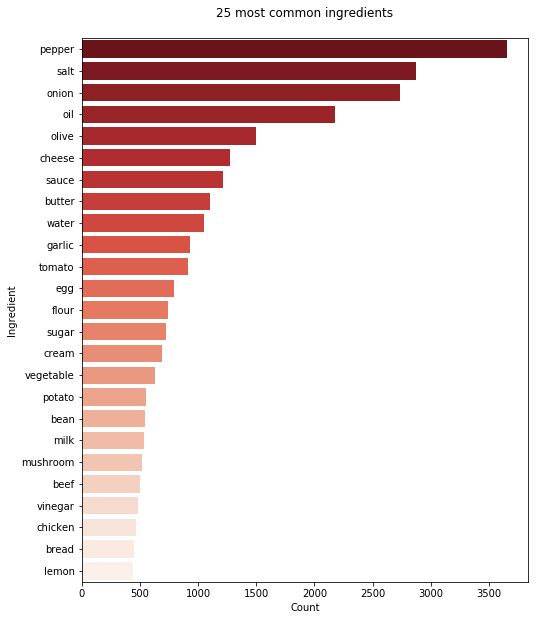

In [23]:
plot_ingredient(df_count, top_n=25)

# Topic Modeling

## LDA using gensim

### Create dictionary and corpus

In [24]:
# create Dictionary
id2word = corpora.Dictionary(data_clean)

# create corpus
texts = data_clean

# term doc frequency - mapping of (word_id, word_frequency)
corpus = [id2word.doc2bow(text) for text in texts]

In [25]:
corpus[0]

[(0, 1), (1, 1), (2, 1), (3, 1)]

### Build LDA model

In [35]:
# Build LDA model using default settings
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=10, 
                                       random_state=100,
                                       chunksize=100, 
                                       passes=10, 
                                       per_word_topics=True)

# chunksize - how many docs are processed at a time in the training algorithm
# passes - how often we train the model on the entire corpus

In [36]:
# print keywords in the 10 topics
pprint(lda_model.print_topics())

[(0,
  '0.096*"lemon" + 0.086*"shrimp" + 0.081*"butter" + 0.080*"pepper" + '
  '0.078*"salmon" + 0.064*"juice" + 0.057*"salt" + 0.046*"parsley" + '
  '0.042*"garlic" + 0.031*"wine"'),
 (1,
  '0.116*"onion" + 0.089*"carrot" + 0.088*"celery" + 0.087*"pepper" + '
  '0.082*"salt" + 0.075*"water" + 0.072*"potato" + 0.053*"beef" + 0.040*"pea" '
  '+ 0.035*"mushroom"'),
 (2,
  '0.166*"cream" + 0.082*"onion" + 0.077*"cheese" + 0.070*"soup" + '
  '0.066*"mushroom" + 0.049*"corn" + 0.045*"pepper" + 0.041*"sour" + '
  '0.033*"butter" + 0.026*"cheddar"'),
 (3,
  '0.159*"bread" + 0.068*"crumb" + 0.066*"egg" + 0.056*"pork" + 0.053*"salt" + '
  '0.049*"butter" + 0.048*"pepper" + 0.038*"italian" + 0.027*"milk" + '
  '0.025*"margarine"'),
 (4,
  '0.183*"cheese" + 0.088*"egg" + 0.079*"pepper" + 0.076*"onion" + '
  '0.062*"salt" + 0.054*"potato" + 0.049*"mayonnaise" + 0.045*"cheddar" + '
  '0.034*"sweet" + 0.033*"mustard"'),
 (5,
  '0.099*"pepper" + 0.094*"onion" + 0.067*"chicken" + 0.059*"salt" + '
  '0

In [37]:
# compute baseline Coherence score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_clean, 
                                     dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', np.round(coherence_lda, 3))

# compute Perplexity: the lower the better
perplexity = lda_model.log_perplexity(corpus)
print('\nPerplexity: ', np.round(perplexity, 2)) 

Coherence Score:  0.385

Perplexity:  -4.85


In [38]:
# visualize the topics
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
LDAvis_prepared

/Users/fivecentsly/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8     -0.113020  0.177519       1        1  14.821866
9     -0.135762 -0.013410       2        1  14.080127
5     -0.098193  0.053134       3        1  13.219179
7     -0.186353  0.033060       4        1  12.404325
6      0.279003  0.206314       5        1   9.466656
2      0.063662 -0.186397       6        1   8.837726
4      0.092104 -0.227753       7        1   7.055541
0     -0.044868  0.025463       8        1   6.982975
1     -0.075653 -0.071000       9        1   6.860802
3      0.219077  0.003071      10        1   6.270804, topic_info=    Category         Freq       Term        Total  loglift  logprob
36   Default  1474.000000      olive  1474.000000  30.0000  30.0000
19   Default  1140.000000      sauce  1140.000000  29.0000  29.0000
32   Default  1269.000000     cheese  1269.000000  28.0000  28.0000
74   Default   677.000000      cream   677.000000  27.0000  27.0000
61   Default   461.000000      bread   461.000000  26.0000  26.0000
37   Default   684.000000      sugar   684.000000  25.0000  25.0000
53   Default   829.000000        egg   829.000000  24.0000  24.0000
0    Default  2170.000000        oil  2170.000000  23.0000  23.0000
34   Default   712.000000      flour   712.000000  22.0000  22.0000
31   Default  1100.000000     butter  1100.000000  21.0000  21.0000
13   Default   411.000000      lemon   411.000000  20.0000  20.0000
11   Default   394.000000     celery   394.000000  19.0000  19.0000
1    Default   598.000000     potato   598.000000  18.0000  18.0000
54   Default   553.000000       milk   553.000000  17.0000  17.0000
79   Default   341.000000     carrot   341.000000  16.0000  16.0000
29   Default   576.000000       bean   576.000000  15.0000  15.0000
99   Default   445.000000    chicken   445.000000  14.0000  14.0000
84   Default   278.000000     shrimp   278.000000  13.0000  13.0000
51   Default   599.000000   mushroom   599.000000  12.0000  12.0000
120  Default   352.000000      broth   352.000000  11.0000  11.0000
14   Default  2701.000000      onion  2701.000000  10.0000  10.0000
221  Default   286.000000       soup   286.000000   9.0000   9.0000
7    Default   357.000000      juice   357.000000   8.0000   8.0000
15   Default   252.000000     salmon   252.000000   7.0000   7.0000
3    Default   648.000000  vegetable   648.000000   6.0000   6.0000
217  Default   312.000000        soy   312.000000   5.0000   5.0000
10   Default   861.000000     tomato   861.000000   4.0000   4.0000
48   Default  1076.000000      water  1076.000000   3.0000   3.0000
114  Default   197.000000      crumb   197.000000   2.0000   2.0000
90   Default   385.000000    vinegar   385.000000   1.0000   1.0000
..       ...          ...        ...          ...      ...      ...
744  Topic10     6.269825  available     7.179042   2.6338  -6.1335
728  Topic10     6.053557       butt     6.962221   2.6294  -6.1686
317  Topic10     5.800371      vital     6.709284   2.6237  -6.2113
839  Topic10     5.741943  cornflake     6.650595   2.6224  -6.2215
847  Topic10     5.602368    catfish     6.511149   2.6189  -6.2461
133  Topic10    62.100960      roast    73.011276   2.6074  -3.8405
527  Topic10     5.010284        nut     5.918962   2.6026  -6.3578
134  Topic10     4.796368       loaf     5.704967   2.5958  -6.4014
929  Topic10     4.702007     island     5.610713   2.5926  -6.4213
916  Topic10     4.057891      steel     4.967153   2.5671  -6.5686
315  Topic10     3.825527     creole     4.734189   2.5562  -6.6276
24   Topic10    37.672997      pecan    52.274689   2.4417  -4.3403
181  Topic10   161.632370       pork   287.988495   2.1917  -2.8839
533  Topic10    21.175898   crabmeat    39.151993   2.1547  -4.9164
50   Topic10   111.110855    italian   349.893738   1.6222  -3.2587
53   Topic10   189.680115        egg   829.722900   1.2935  -2.7239
109  Topic10    48.694016    sausage   194.86

### Tune hyperparameters 

In [39]:
# supporting function
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b,
                                           per_word_topics=True)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_clean, dictionary=id2word, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [40]:
grid = {}
grid['Validation_Set'] = {}

# topics range
topics_range = range(2, 11, 1)

# alpha parameter
alpha = [0.01, 0.1, 1, 'symmetric', 'asymmetric']

# beta parameter
beta = [0.01, 0.1, 1, 'symmetric']

# validation sets
num_of_docs = len(corpus)
corpus_sets = [corpus[:int(num_of_docs*0.75)], corpus]
corpus_title = ['75% Corpus', '100% Corpus']
model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []}

In [41]:
# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=540)
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=id2word, 
                                                  k=k, a=a, b=b)
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)
                    
                    pbar.update(1)
    pd.DataFrame(model_results).to_csv('lda_tuning_results.csv', index=False)
    pbar.close()

 67%|██████▋   | 360/540 [49:24<28:11,  9.40s/it] 


In [42]:
df_result = pd.read_csv('lda_tuning_results.csv')
df_result.head()

,Validation_Set,Topics,Alpha,Beta,Coherence
0,75% Corpus,2,0.01,0.01,0.344814
1,75% Corpus,2,0.01,0.1,0.332463
2,75% Corpus,2,0.01,1,0.353572
3,75% Corpus,2,0.01,symmetric,0.346246
4,75% Corpus,2,0.1,0.01,0.345094


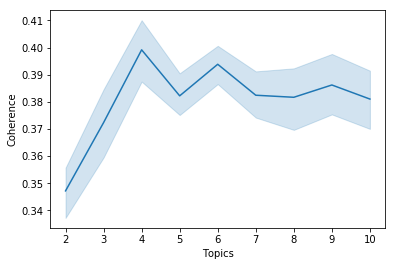

In [43]:
# visualize c_v score vs topics in 75% corpus
df_result_75 = df_result[df_result.Validation_Set == '75% Corpus']
sns.lineplot(data=df_result_75, x='Topics', y='Coherence');

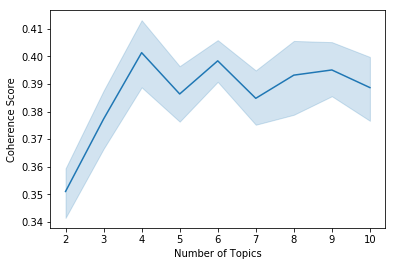

In [44]:
# visualize c_v score vs # topics in 100% corpus
df_result_100 = df_result[df_result.Validation_Set == '100% Corpus']
sns.lineplot(data=df_result_100, x='Topics', y='Coherence')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score');

#### The best number of topics is 4 or 6.

In [92]:
# look for the best alpha and beta based on c_v score
df_result_100[df_result_100.Topics == 8].sort_values('Coherence', ascending=False)[:5]

,Validation_Set,Topics,Alpha,Beta,Coherence
306,100% Corpus,8,0.1,1,0.441330
302,100% Corpus,8,0.01,1,0.439964
314,100% Corpus,8,symmetric,1,0.422408
307,100% Corpus,8,0.1,symmetric,0.418836
301,100% Corpus,8,0.01,0.1,0.415906


#### With alpha of asymmetric and beta of 1, I can achieve 13.5% improvement in coherence score over the baseline.

In [93]:
# build the final model
lda_model_final = gensim.models.LdaMulticore(corpus=corpus,
                                             id2word=id2word,
                                             num_topics=8, 
                                             random_state=100,
                                             chunksize=100,
                                             passes=10,
                                             alpha=0.1,
                                             eta=1)

In [94]:
# visualize the topics
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model_final, corpus, id2word)
LDAvis_prepared

/Users/fivecentsly/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6      0.132770  0.061463       1        1  17.163906
0      0.070822  0.083692       2        1  16.211897
7      0.153748 -0.013224       3        1  15.689457
5      0.065001 -0.089442       4        1  15.061352
2     -0.104259  0.161365       5        1  14.130360
3      0.010305 -0.170222       6        1   9.236763
4     -0.255834 -0.053999       7        1   7.678929
1     -0.072554  0.020367       8        1   4.827332, topic_info=     Category         Freq             Term        Total  loglift  logprob
32    Default  1048.000000           cheese  1048.000000  30.0000  30.0000
1     Default   480.000000           potato   480.000000  29.0000  29.0000
19    Default  1050.000000            sauce  1050.000000  28.0000  28.0000
74    Default   617.000000            cream   617.000000  27.0000  27.0000
36    Default  1283.000000            olive  1283.000000  26.0000  26.0000
37    Default   597.000000            sugar   597.000000  25.0000  25.0000
34    Default   615.000000            flour   615.000000  24.0000  24.0000
31    Default   939.000000           butter   939.000000  23.0000  23.0000
29    Default   501.000000             bean   501.000000  22.0000  22.0000
0     Default  1883.000000              oil  1883.000000  21.0000  21.0000
54    Default   470.000000             milk   470.000000  20.0000  20.0000
53    Default   654.000000              egg   654.000000  19.0000  19.0000
10    Default   805.000000           tomato   805.000000  18.0000  18.0000
3     Default   573.000000        vegetable   573.000000  17.0000  17.0000
50    Default   340.000000          italian   340.000000  16.0000  16.0000
71    Default   434.000000             beef   434.000000  15.0000  15.0000
13    Default   360.000000            lemon   360.000000  14.0000  14.0000
221   Default   263.000000             soup   263.000000  13.0000  13.0000
8     Default  3137.000000           pepper  3137.000000  12.0000  12.0000
217   Default   266.000000              soy   266.000000  11.0000  11.0000
51    Default   523.000000         mushroom   523.000000  10.0000  10.0000
30    Default   254.000000            brown   254.000000   9.0000   9.0000
181   Default   266.000000             pork   266.000000   8.0000   8.0000
79    Default   292.000000           carrot   292.000000   7.0000   7.0000
132   Default   203.000000          cheddar   203.000000   6.0000   6.0000
26    Default   184.000000            sweet   184.000000   5.0000   5.0000
21    Default   115.000000       mayonnaise   115.000000   4.0000   4.0000
11    Default   343.000000           celery   343.000000   3.0000   3.0000
33    Default   269.000000             corn   269.000000   2.0000   2.0000
204   Default   149.000000           ginger   149.000000   1.0000   1.0000
...       ...          ...              ...          ...      ...      ...
1021   Topic8     2.176458         charcoal     8.255048   1.6978  -6.9300
738    Topic8     2.575552             high     9.905118   1.6839  -6.7616
812    Topic8     2.767379             stem    10.805242   1.6687  -6.6898
589    Topic8     4.652261             neck    18.982292   1.6247  -6.1703
17     Topic8     2.221386          granule     9.135164   1.6169  -6.9095
856    Topic8     2.857835             base    12.333723   1.5686  -6.6576
687    Topic8     3.710485             peel    16.437052   1.5425  -6.3965
11     Topic8    74.667740           celery   343.422974   1.5050  -3.3946
981    Topic8     1.751804         gram_yve     8.123398   1.4968  -7.1470
625    Topic8     1.997222             sole     9.457570   1.4758  -7.0159
522    Topic8     1.932665           relish     9.167505   1.4741  -7.0488
188    Topic8    27.609968          paprika   134.452637   1.4478  -4.3895
28     Topic8    31.793751          mustard   188.969986   1.2486  -4.2484
483    Topic8     3.168115  saltine_cracke

In [121]:
pyLDAvis.save_html(LDAvis_prepared, 'recipe_lda.html')

In [95]:
# print keywords in the 8 topics
pprint(lda_model_final.print_topics())
doc_lda = lda_model_final[corpus]

[(0,
  '0.095*"pepper" + 0.076*"salt" + 0.060*"butter" + 0.044*"lemon" + '
  '0.043*"onion" + 0.041*"oil" + 0.034*"olive" + 0.031*"chicken" + '
  '0.028*"juice" + 0.027*"thyme"'),
 (1,
  '0.119*"potato" + 0.049*"mayonnaise" + 0.042*"onion" + 0.040*"sweet" + '
  '0.039*"carrot" + 0.034*"celery" + 0.029*"salt" + 0.026*"pepper" + '
  '0.023*"pea" + 0.017*"dill"'),
 (2,
  '0.092*"cheese" + 0.085*"cream" + 0.068*"onion" + 0.048*"pepper" + '
  '0.044*"butter" + 0.044*"mushroom" + 0.042*"salt" + 0.039*"soup" + '
  '0.036*"milk" + 0.032*"potato"'),
 (3,
  '0.080*"oil" + 0.062*"vegetable" + 0.048*"sauce" + 0.038*"onion" + '
  '0.038*"soy" + 0.033*"ginger" + 0.032*"crumb" + 0.032*"bread" + '
  '0.028*"water" + 0.025*"egg"'),
 (4,
  '0.096*"sugar" + 0.093*"flour" + 0.065*"salt" + 0.062*"egg" + 0.056*"butter" '
  '+ 0.052*"milk" + 0.039*"brown" + 0.034*"water" + 0.017*"walnut" + '
  '0.013*"cranberry"'),
 (5,
  '0.098*"sauce" + 0.095*"pepper" + 0.066*"onion" + 0.054*"salt" + '
  '0.046*"beef" + 0.

In [96]:
doc_lda[0]

[(0, 0.0208431),
 (1, 0.35198727),
 (2, 0.02083906),
 (3, 0.5229652),
 (4, 0.02084005),
 (5, 0.020840116),
 (6, 0.020842856),
 (7, 0.02084229)]

In [97]:
# create a df to show lda matrix
lda_dict = {0: [], 1: [], 2: [], 3: [], 4: [], 5:[], 6:[], 7:[]}

for _ in range(len(doc_lda)):
    for key in list(lda_dict.keys()):
        lda_dict[key].append(0)

# create a df filled with 0
lda_matrix = pd.DataFrame(lda_dict)

# fill the probability distribution of topics for each row
for i, row in enumerate(doc_lda):
    for j, (topic, prop_topic) in enumerate(row):
        lda_matrix.loc[i, topic] = prop_topic

In [98]:
lda_matrix.head()

,0,1,2,3,4,5,6,7
0,0.020843,0.351927,0.020839,0.523025,0.020840,0.020840,0.020843,0.020842
1,0.010208,0.436187,0.010207,0.010207,0.010207,0.010210,0.010207,0.502567
2,0.910243,0.012825,0.012822,0.012821,0.012821,0.012822,0.012822,0.012823
3,0.012826,0.012827,0.012824,0.012824,0.012823,0.910225,0.012825,0.012826
4,0.000000,0.693312,0.000000,0.000000,0.000000,0.000000,0.255822,0.000000


In [99]:
lda_matrix.shape

(4776, 8)

In [100]:
# add recipe name
lda_matrix = lda_matrix.merge(df, left_index=True, right_index=True, how='inner')
lda_matrix.head()

,0,1,2,3,4,5,6,7,title,ingredients
0,0.020843,0.351927,0.020839,0.523025,0.020840,0.020840,0.020843,0.020842,Chip Truck Fries,"6 baking potatoes, cut into 1/4 inch slices,1/..."
1,0.010208,0.436187,0.010207,0.010207,0.010207,0.010210,0.010207,0.502567,Irish Bacon And Cabbage Soup,"1/2 pound Irish bacon, diced,2 large potatoes,..."
2,0.910243,0.012825,0.012822,0.012821,0.012821,0.012822,0.012822,0.012823,Quick Salmon Salad,"2 (6 ounce) cans pink salmon, drained,1/2 cup ..."
3,0.012826,0.012827,0.012824,0.012824,0.012823,0.910225,0.012825,0.012826,Bills Seasoned Ketchup,"1 (28 ounce) bottle ketchup,2 teaspoons hot pe..."
4,0.000000,0.693312,0.000000,0.000000,0.000000,0.000000,0.255822,0.000000,Celery Salad,"3/4 cup sliced celery,1/3 cup dried sweet cher..."


In [102]:
# assign topic names using my judgement
lda_matrix.sort_values(by=0, ascending=False)[:5]
# topic 0 looks like seafood

,0,1,2,3,4,5,6,7,title,ingredients
1618,0.960668,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Chef Johns Grilled Garlic And Herb Shrimp,"1 1/2 teaspoons kosher salt,1/2 teaspoon lemon..."
2343,0.960667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Seared Salmon With Indian Inspired Cream Sauce,"4 (6 ounce) fillets fresh salmon,salt and blac..."
3085,0.958325,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Filet Mignon With Garlic Shrimp Cream Sauce,2 (4 ounce) 1 1/2 inch thick filet mignon stea...
1454,0.955690,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Shrimp Scampi With Pasta,"1 (16 ounce) package linguine pasta,2 tablespo..."
3476,0.955689,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Absolutely The Best Shrimp Scampi,"1/2 cup all-purpose flour,1/4 teaspoon salt,1/..."


In [104]:
lda_matrix.sort_values(by=1, ascending=False)[:5]
# topic 1 looks like salad

,0,1,2,3,4,5,6,7,title,ingredients
934,0.000000,0.945296,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,New Wife Tuna Salad,"4 (5 ounce) cans tuna, drained,5 hard-boiled e..."
275,0.000000,0.940660,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Imas Potato Salad,"2 pounds russet potatoes, peeled,3/4 cup mayon..."
304,0.010208,0.928553,0.010206,0.010206,0.010207,0.010207,0.010207,0.010207,Potato Salad Deviled Eggs,"8 eggs,1 large potato, coarsely chopped,2 teas..."
279,0.010207,0.928549,0.010207,0.010207,0.010208,0.010207,0.010207,0.010208,Hawaiian Bruddah Potato Mac Macaroni Salad,"5 eggs,7 large potatoes, peeled and cubed,1 cu..."
938,0.010207,0.928549,0.010207,0.010207,0.010208,0.010207,0.010207,0.010208,Amish Macaroni Salad,"2 cups uncooked elbow macaroni,3 hard-cooked e..."


In [106]:
lda_matrix.sort_values(by=2, ascending=False)[:5]
# topic 2 looks like cream-based

,0,1,2,3,4,5,6,7,title,ingredients
1442,0.0,0.0,0.962754,0.0,0.0,0.0,0.0,0.0,Cheater Pierogi,"2 teaspoons butter,4 slices bacon, chopped,2 t..."
3541,0.0,0.0,0.958325,0.0,0.0,0.0,0.0,0.0,Crawfish Chowder,"1/4 cup butter,1/2 bunch green onions, chopped..."
1392,0.0,0.0,0.958322,0.0,0.0,0.0,0.0,0.0,Chef Johns Turkey Noodle Casserole,"12 ounces egg noodles,3 tablespoons butter,3 t..."
2878,0.0,0.0,0.958322,0.0,0.0,0.0,0.0,0.0,Heavenly Potatoes And Ham,"5 pounds red potatoes, quartered,1 (16 ounce) ..."
4567,0.0,0.0,0.958318,0.0,0.0,0.0,0.0,0.0,Seafood Chowder,"1 1/2 cups fat free milk,1 (8 ounce) container..."


In [108]:
lda_matrix.sort_values(by=3, ascending=False)[:5]
# topic 3 looks like Asian cuisine

,0,1,2,3,4,5,6,7,title,ingredients
2974,0.0,0.0,0.0,0.964640,0.0,0.0,0.0,0.0,Turkey Lettuce Wraps With Shiitake Mushrooms,"2 cups water,2 ounces mai fun (angel hair) ric..."
2909,0.0,0.0,0.0,0.962756,0.0,0.0,0.0,0.0,Sukhothai Pad Thai,"1/2 cup white sugar,1/2 cup distilled white vi..."
846,0.0,0.0,0.0,0.960667,0.0,0.0,0.0,0.0,Carries Pad Thai Salad,"1 (12 ounce) package dried rice noodles,1/2 cu..."
3608,0.0,0.0,0.0,0.958321,0.0,0.0,0.0,0.0,Zen Garden Pad Thai,"1/3 cup naturally brewed soy sauce,3 tablespoo..."
1496,0.0,0.0,0.0,0.955684,0.0,0.0,0.0,0.0,Spicy Crispy Beef,"1/4 cup cornstarch,1/4 tablespoon salt,black p..."


In [110]:
lda_matrix.sort_values(by=4, ascending=False)[:5]
# topic 4 looks like baking goods

,0,1,2,3,4,5,6,7,title,ingredients
858,0.0,0.0,0.0,0.0,0.958328,0.0,0.0,0.0,Crunchy Wheat And Rye,"1 1/3 cups water,2 tablespoons honey,3 tablesp..."
51,0.0,0.0,0.0,0.0,0.958323,0.0,0.0,0.0,Danish Spiced Rye Bread Sigtebrod,"1 cup milk,1 cup water,3 tablespoons butter,1/..."
2024,0.0,0.0,0.0,0.0,0.949272,0.0,0.0,0.0,Chocolate Revel Bars,"3 cups quick cooking oats,2 1/2 cups all-purpo..."
2029,0.0,0.0,0.0,0.0,0.949272,0.0,0.0,0.0,Oatmeal Whoopie Pies,"2 cups packed brown sugar,3/4 cup butter,2 egg..."
3898,0.0,0.0,0.0,0.0,0.949267,0.0,0.0,0.0,Crisp Peach Cobbler,"6 large fresh peaches, pitted and cut into eig..."


In [112]:
lda_matrix.sort_values(by=5, ascending=False)[:5]
# topic 5 looks like meat

,0,1,2,3,4,5,6,7,title,ingredients
1664,0.0,0.0,0.0,0.0,0.0,0.973875,0.0,0.0,North Carolina Style Pulled Pork,"1 tablespoon mild paprika,2 teaspoons light br..."
3187,0.0,0.0,0.0,0.0,0.0,0.973874,0.0,0.0,Good New Orleans Creole Gumbo,"1 cup all-purpose flour,3/4 cup bacon dripping..."
1199,0.0,0.0,0.0,0.0,0.0,0.962755,0.0,0.0,Texas Pork Ribs,"6 pounds pork spareribs,1 1/2 cups white sugar..."
1630,0.0,0.0,0.0,0.0,0.0,0.962754,0.0,0.0,Home Cured Holiday Ham,"1 (7 pound) fresh, bone-in pork shoulder (""pic..."
3933,0.0,0.0,0.0,0.0,0.0,0.960666,0.0,0.0,A Minnesotans Beef And Macaroni Hotdish,"1 pound ground beef,2 cups elbow macaroni,1/2 ..."


In [114]:
lda_matrix.sort_values(by=6, ascending=False)[:5]
# topic 6 looks like Italian cuisine

,0,1,2,3,4,5,6,7,title,ingredients
1544,0.0,0.0,0.0,0.0,0.0,0.0,0.964638,0.0,Chef Johns Spaghetti Al Tonno,"2 tablespoons olive oil,1 anchovy fillet,2 tab..."
1663,0.0,0.0,0.0,0.0,0.0,0.0,0.964636,0.0,Chef Johns Spaghetti With Red Clam Sauce,"2 tablespoons olive oil,3 cloves garlic,2 tabl..."
3299,0.0,0.0,0.0,0.0,0.0,0.0,0.962756,0.0,Disneys Ratatouille,"1 (6 ounce) can tomato paste,1/2 onion, choppe..."
87,0.0,0.0,0.0,0.0,0.0,0.0,0.960667,0.0,Easy Tomato Basil Pizza,"2 tomatoes, seeded and coarsely chopped,1 teas..."
1595,0.0,0.0,0.0,0.0,0.0,0.0,0.960664,0.0,Simple Spinach Lasagna,"1 tablespoon extra virgin olive oil,2 (10 ounc..."


In [116]:
lda_matrix.sort_values(by=7, ascending=False)[:5]
# topic 7 looks like Mexican

,0,1,2,3,4,5,6,7,title,ingredients
328,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.967883,Hearty Vegan Slow Cooker Chili,"1 tablespoon olive oil,1 green bell pepper, ch..."
4437,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.964642,The Best Vegetarian Chili In The World,"1 tablespoon olive oil,1/2 medium onion, chopp..."
3195,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.960669,Quinoa And Black Bean Chili,"1 cup uncooked quinoa, rinsed,2 cups water,1 t..."
3242,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.960669,Turkey Taco Soup,"2 tablespoons olive oil,1 1/4 pounds ground tu..."
13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.958328,Black Bean Corn And Tomato Salad With Feta Cheese,"1 (14 ounce) can black beans, drained and rins..."


In [117]:
# drop ingredients columns 
lda_matrix.drop('ingredients', axis=1, inplace=True)

# change column name
lda_matrix.columns = ['seafood','salad','cream_based','asian','baking_goods','meat','italian','mexican','title']
lda_matrix.head()

,seafood,salad,cream_based,asian,baking_goods,meat,italian,mexican,title
0,0.020843,0.351927,0.020839,0.523025,0.020840,0.020840,0.020843,0.020842,Chip Truck Fries
1,0.010208,0.436187,0.010207,0.010207,0.010207,0.010210,0.010207,0.502567,Irish Bacon And Cabbage Soup
2,0.910243,0.012825,0.012822,0.012821,0.012821,0.012822,0.012822,0.012823,Quick Salmon Salad
3,0.012826,0.012827,0.012824,0.012824,0.012823,0.910225,0.012825,0.012826,Bills Seasoned Ketchup
4,0.000000,0.693312,0.000000,0.000000,0.000000,0.000000,0.255822,0.000000,Celery Salad


In [118]:
lda_matrix.set_index('title', inplace=True)

In [122]:
lda_matrix.head(8)

,seafood,salad,cream_based,asian,baking_goods,meat,italian,mexican
title,,,,,,,,
Chip Truck Fries,0.020843,0.351927,0.020839,0.523025,0.020840,0.020840,0.020843,0.020842
Irish Bacon And Cabbage Soup,0.010208,0.436187,0.010207,0.010207,0.010207,0.010210,0.010207,0.502567
Quick Salmon Salad,0.910243,0.012825,0.012822,0.012821,0.012821,0.012822,0.012822,0.012823
Bills Seasoned Ketchup,0.012826,0.012827,0.012824,0.012824,0.012823,0.910225,0.012825,0.012826
Celery Salad,0.000000,0.693312,0.000000,0.000000,0.000000,0.000000,0.255822,0.000000
Jens Heavenly Egg Salad,0.879288,0.017245,0.017245,0.017243,0.017242,0.017247,0.017244,0.017245
Black Bean And Corn Quesadillas,0.000000,0.000000,0.141901,0.000000,0.290849,0.000000,0.000000,0.528182
Mimis Zucchini Pie,0.000000,0.000000,0.000000,0.000000,0.099931,0.000000,0.844503,0.000000


In [119]:
# save lda_matrix
lda_matrix.to_csv('recipe_lda.csv')

In [120]:
lda_matrix.shape

(4776, 8)

References:

http://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/

https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/